In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:0

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [3]:
hotel_data = pd.read_csv('hotel_bookings.csv', encoding = 'latin1')

hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/07/15


In [4]:
# Cargar datos
hotel_data = pd.read_csv('hotel_bookings.csv', encoding='latin1')

# Crear columna de fecha 'date' en formato datetime
hotel_data['arrival_date_month'] = pd.to_datetime(hotel_data['arrival_date_month'], format='%B').dt.month
hotel_data['date'] = pd.to_datetime(
    hotel_data[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].rename(
        columns={'arrival_date_year': 'year', 'arrival_date_month': 'month', 'arrival_date_day_of_month': 'day'}
    )
)

# Filtrar datos para City Hotel y reservas no canceladas
city_not_canceled = hotel_data[(hotel_data['hotel'] == 'City Hotel') & (hotel_data['is_canceled'] == 0)]

# Crear la columna 'asistentes'
city_not_canceled['asistentes'] = city_not_canceled['adults'] + city_not_canceled['children']

# Agrupar por fecha y sumar asistentes
time_series_data = city_not_canceled.groupby('date')['asistentes'].sum().reset_index()

# Convertir la columna 'date' a índice de fecha
time_series_data.set_index('date', inplace=True)


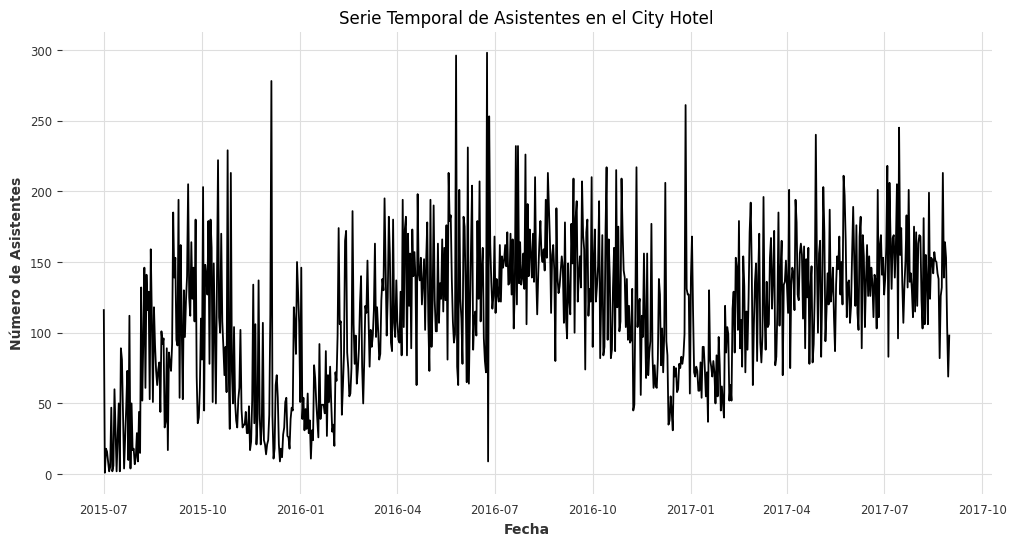

In [5]:
# Crear la figura y graficar
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data['asistentes'])
plt.title('Serie Temporal de Asistentes en el City Hotel')
plt.xlabel('Fecha')
plt.ylabel('Número de Asistentes')
plt.show()


In [9]:
time_series_data

,asistentes
date,
2015-07-01,116.0
2015-07-02,1.0
2015-07-03,18.0
2015-07-04,16.0
2015-07-06,2.0
...,...
2017-08-27,164.0
2017-08-28,153.0
2017-08-29,105.0


In [7]:
# Dividir datos en entrenamiento y validación
train_data = time_series_data.loc[:'2017-08-20']
val_data = time_series_data.loc['2017-08-21':]

In [31]:
lb_test = acorr_ljungbox(train_data, lags=[10], return_df=True)
p_value = lb_test['lb_pvalue'].values

In [32]:
p_value

array([9.48121848e-277])

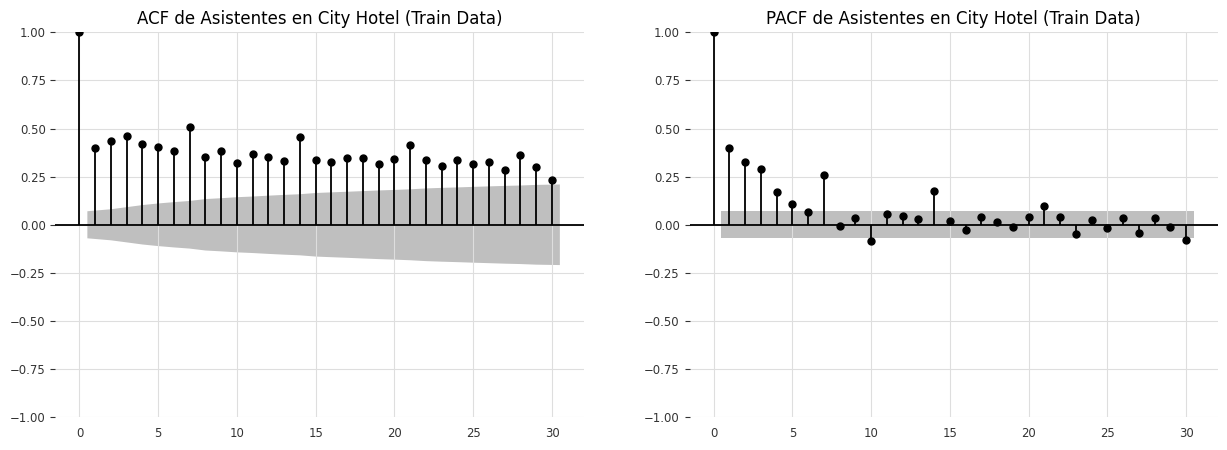

In [12]:
# Crear la figura y graficar ACF y PACF de train_data['asistentes']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_data['asistentes'], lags=30, ax=axes[0])
axes[0].set_title('ACF de Asistentes en City Hotel (Train Data)')

plot_pacf(train_data['asistentes'], lags=30, ax=axes[1])
axes[1].set_title('PACF de Asistentes en City Hotel (Train Data)')

plt.show()

In [23]:
model_1 = ARIMA(train_data, order=(1, 0, 0))
results_1 = model_1.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_1.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1724.8873662117296


In [25]:
model_2 = ARIMA(train_data, order=(2, 0, 0))
results_2 = model_2.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_2.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1620.655627096609


In [26]:
model_3 = ARIMA(train_data, order=(3, 0, 0))
results_3 = model_3.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_3.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1485.3406112259286


In [27]:
model_4 = ARIMA(train_data, order=(4, 0, 0))
results_4 = model_4.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_4.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1460.122536179695


In [28]:
model_5 = ARIMA(train_data, order=(5, 0, 0))
results_5 = model_5.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_5.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1482.718804393683


In [30]:
model_6 = ARIMA(train_data, order=(1, 0, 1))
results_6 = model_6.fit()
start = len(train_data)
end = start + len(val_data) - 1
predictions = results_6.predict(start=start, end=end, typ='levels')

# Evaluar el modelo utilizando métricas de error en val_data
mse = mean_squared_error(val_data, predictions)
print(mse)

1669.993548264698
